In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
while True:
  x = 1

# Dataset/Pretraining stuff

In [ ]:
labels = np.load('/content/drive/My Drive/Colab Notebooks/labels.npy')
audios = np.load('/content/drive/My Drive/Colab Notebooks/audios.npy')

from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
import scipy
from scipy import signal, fft
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import cv2
import time
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1, l2


In [ ]:
# https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520

def spectrogram(samples, sample_rate=44100, stride_ms = 20.0, 
                          window_ms = 40.0, max_freq = None, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    
    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    
    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    return specgram

In [ ]:
import librosa
import librosa.display

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import cv2
sr = 44100
# A2S = Audio sequence to spectrogram

# Dont convert to 64x64

def a2s(audio_sequence, sampling_rate=sr,):
    cut_audio = audio_sequence#[audio_sequence!=0]

    spec = spectrogram(cut_audio, sample_rate = sampling_rate, max_freq = 11025)
    return spec

In [ ]:
# Uncut audios
import time

start = time.time()
specs = np.apply_along_axis(a2s, 1, audios)

print(time.time() - start)

17.30528998374939


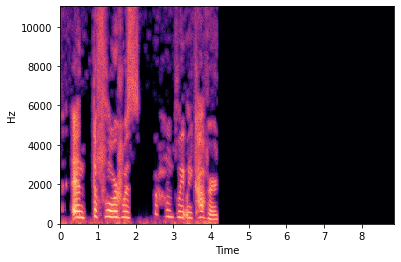

In [ ]:
librosa.display.specshow(specs[911], sr=22050, x_axis='time', y_axis='hz')

In [ ]:
print(specs.shape)
from keras.callbacks import History

(1272, 442, 382)


In [ ]:
mask = np.logical_or(labels=='other', labels=='X')

labels = labels[~mask]
specs = specs[~mask]

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize

np.sum(label_binarize(labels, classes=['angry', 'happy', 'sad', 'neutral']), axis=0)

array([284, 224, 186, 524])

In [ ]:
def plothist(hist):
      plt.plot(hist.history['loss'])
      plt.plot(hist.history['val_loss'])
      plt.title('Model Loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper right')
      plt.show()

      plt.plot(hist.history['accuracy'])
      plt.plot(hist.history['val_accuracy'])
      plt.title('Model Accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper left')
      plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

In [ ]:
from keras.layers import Reshape, ConvLSTM2D

def create_model(num_filters_1, num_filters_2, lstm_units, dense_units, dropout_rate, l1_reg, learning_rate):
    model = Sequential()

    model.add(Conv2D(num_filters_1, (3, 3), activation='relu', input_shape=(442, 382, 1), kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Conv2D(num_filters_2, (3, 3), activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(AveragePooling2D(pool_size=(3, 3)))
    model.add(Reshape((-1, 48, 41, num_filters_2)))
    model.add(ConvLSTM2D(filters=lstm_units, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize

In [ ]:
model = create_model(32, 64, 128, 128, 0.5, 0.001, 0.0001)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


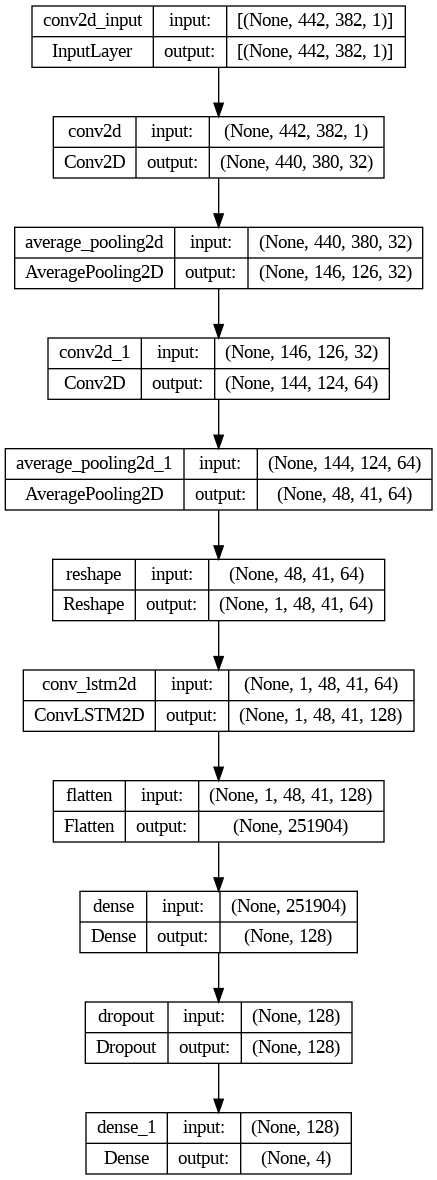

In [ ]:
from keras.utils.vis_utils import plot_model
!pip3 install keras-visualizer

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Evaluation

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize

In [ ]:
### MANUAL 4 FOLD EVALUATION

In [ ]:

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import History

# Define the number of folds
n_folds = 4

# Create a list to store the performance metrics for each fold
metrics_per_fold = []

# Create the K-fold cross-validator
skf = StratifiedKFold(n_splits=n_folds)
trx = []
tsx = []
# Iterate over the folds
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(specs, labels)):
      trx.append(train_idx)
      tsx.append(test_idx)

# FOLD 1

In [ ]:
### FOLD 1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize

X_train, y_train = specs[trx[0]], labels[trx[0]]
X_test, y_test = specs[tsx[0]], labels[tsx[0]]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=727)
y_bin = label_binarize(y_train, classes=['angry', 'happy', 'sad', 'neutral',])
y_bin2 = label_binarize(y_test, classes=['angry', 'happy', 'sad', 'neutral',])
y_val_bin = label_binarize(y_val, classes=['angry', 'happy', 'sad', 'neutral',])

Epoch 1/25
23/23 [==============================] - 8s 192ms/step - loss: 37.6466 - accuracy: 0.3219 - val_loss: 17.0312 - val_accuracy: 0.4863
Epoch 2/25
23/23 [==============================] - 4s 162ms/step - loss: 10.9169 - accuracy: 0.4082 - val_loss: 6.6105 - val_accuracy: 0.4863
Epoch 3/25
23/23 [==============================] - 4s 164ms/step - loss: 5.2498 - accuracy: 0.4137 - val_loss: 4.2377 - val_accuracy: 0.4863
Epoch 4/25
23/23 [==============================] - 4s 163ms/step - loss: 3.9814 - accuracy: 0.3973 - val_loss: 3.6973 - val_accuracy: 0.4863
Epoch 5/25
23/23 [==============================] - 4s 165ms/step - loss: 3.6690 - accuracy: 0.4151 - val_loss: 3.4791 - val_accuracy: 0.4863
Epoch 6/25
23/23 [==============================] - 4s 166ms/step - loss: 3.5274 - accuracy: 0.4123 - val_loss: 3.3959 - val_accuracy: 0.4863
Epoch 7/25
23/23 [==============================] - 4s 165ms/step - loss: 3.5040 - accuracy: 0.4055 - val_loss: 3.3910 - val_accuracy: 0.4863
Epo

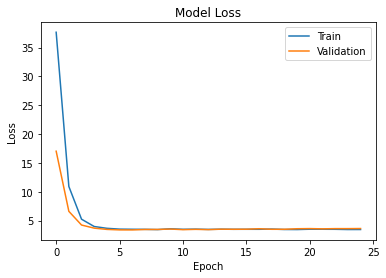

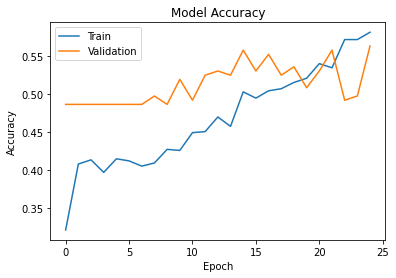

In [ ]:
hist1 = History()
model1 = create_model(32, 64, 128, 128, 0.5, 0.001, 0.0005)
model1.fit(X_train, y_bin, epochs=25, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist1])
plothist(hist1)

In [ ]:
from sklearn.metrics import classification_report

y_pred = model1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model1.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(classification_report(y_arg, y_pred))

10/10 [==============================] - 1s 82ms/step - loss: 21.0946 - accuracy: 0.5344
Test accuracy: 0.534426212310791
F1-score: 0.459003572462399
              precision    recall  f1-score   support

           0       0.94      0.41      0.57        71
           1       0.30      0.14      0.19        56
           2       1.00      0.02      0.04        47
           3       0.51      0.95      0.66       131

    accuracy                           0.53       305
   macro avg       0.68      0.38      0.37       305
weighted avg       0.64      0.53      0.46       305



In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

y_pred = model1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

# Define the class names
class_names = ['angry', 'happy', 'sad', 'neutral']

# Compute the classification report
report = classification_report(y_arg, y_pred, target_names=class_names, output_dict=True)

# Convert the report to a dataframe
df_report = pd.DataFrame(report).transpose()

# Convert the decimals to percentages with 2 decimal places (excluding the last column)
df_report.iloc[:,:-1] = df_report.iloc[:,:-1].applymap(lambda x: f'{x:.2%}' if isinstance(x, float) else x)

# Style the dataframe
df_report = df_report.style.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]).set_precision(2)

# Display the dataframe
display(df_report)

10/10 [==============================] - 1s 85ms/step


<ipython-input-72-e5839b6ff508>:21: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_report = df_report.style.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]).set_precision(2)


,precision,recall,f1-score,support
angry,93.55%,40.85%,56.86%,71.00
happy,29.63%,14.29%,19.28%,56.00
sad,100.00%,2.13%,4.17%,47.00
neutral,50.81%,95.42%,66.31%,131.00
accuracy,53.44%,53.44%,53.44%,0.53
macro avg,68.50%,38.17%,36.65%,305.00
weighted avg,64.45%,53.44%,45.90%,305.00


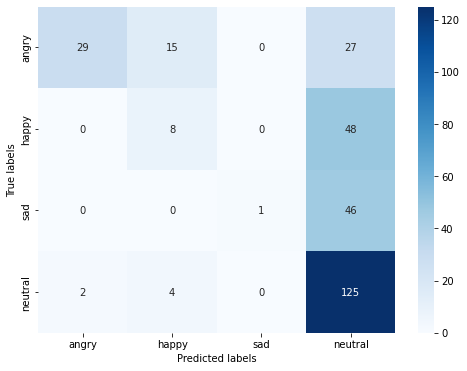

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the class names
class_names = ['angry', 'happy', 'sad', 'neutral']

# Compute the confusion matrix
cm = confusion_matrix(y_arg, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# FOLD 2

In [ ]:
### FOLD 2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize

X_train, y_train = specs[trx[1]], labels[trx[1]]
X_test, y_test = specs[tsx[1]], labels[tsx[1]]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=727)
y_bin = label_binarize(y_train, classes=['angry', 'happy', 'sad', 'neutral',])
y_bin2 = label_binarize(y_test, classes=['angry', 'happy', 'sad', 'neutral',])
y_val_bin = label_binarize(y_val, classes=['angry', 'happy', 'sad', 'neutral',])

Epoch 1/25
23/23 [==============================] - 7s 194ms/step - loss: 42.9519 - accuracy: 0.3000 - val_loss: 21.6217 - val_accuracy: 0.4754
Epoch 2/25
23/23 [==============================] - 4s 167ms/step - loss: 14.5348 - accuracy: 0.3890 - val_loss: 9.0539 - val_accuracy: 0.4754
Epoch 3/25
23/23 [==============================] - 4s 167ms/step - loss: 6.9184 - accuracy: 0.4096 - val_loss: 5.1944 - val_accuracy: 0.4754
Epoch 4/25
23/23 [==============================] - 4s 168ms/step - loss: 4.5580 - accuracy: 0.3932 - val_loss: 4.0845 - val_accuracy: 0.3825
Epoch 5/25
23/23 [==============================] - 4s 169ms/step - loss: 3.8638 - accuracy: 0.3877 - val_loss: 3.5877 - val_accuracy: 0.4754
Epoch 6/25
23/23 [==============================] - 4s 168ms/step - loss: 3.5573 - accuracy: 0.4110 - val_loss: 3.4205 - val_accuracy: 0.4754
Epoch 7/25
23/23 [==============================] - 4s 166ms/step - loss: 3.4292 - accuracy: 0.4205 - val_loss: 3.3791 - val_accuracy: 0.4754
Epo

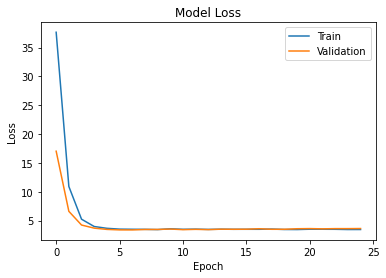

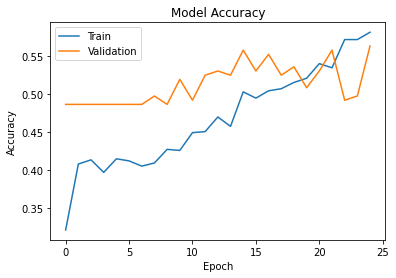

In [ ]:
hist2 = History()
model2 = create_model(32, 64, 128, 128, 0.5, 0.001, 0.0005)
model2.fit(X_train, y_bin, epochs=25, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist2])
plothist(hist1)

In [ ]:
from sklearn.metrics import classification_report

y_pred = model2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model2.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(classification_report(y_arg, y_pred))

10/10 [==============================] - 1s 48ms/step - loss: 3.4058 - accuracy: 0.4623
Test accuracy: 0.4622950851917267
F1-score: 0.3864212416330964
              precision    recall  f1-score   support

           0       0.32      0.45      0.38        71
           1       1.00      0.02      0.04        56
           2       0.33      0.06      0.11        47
           3       0.54      0.80      0.64       131

    accuracy                           0.46       305
   macro avg       0.55      0.33      0.29       305
weighted avg       0.54      0.46      0.39       305



In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

y_pred = model2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

# Define the class names
class_names = ['angry', 'happy', 'sad', 'neutral']

# Compute the classification report
report = classification_report(y_arg, y_pred, target_names=class_names, output_dict=True)

# Convert the report to a dataframe
df_report = pd.DataFrame(report).transpose()

# Convert the decimals to percentages with 2 decimal places (excluding the last column)
df_report.iloc[:,:-1] = df_report.iloc[:,:-1].applymap(lambda x: f'{x:.2%}' if isinstance(x, float) else x)

# Style the dataframe
df_report = df_report.style.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]).set_precision(2)

# Display the dataframe
display(df_report)

10/10 [==============================] - 1s 52ms/step


<ipython-input-82-2a9e75363942>:21: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_report = df_report.style.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]).set_precision(2)


,precision,recall,f1-score,support
angry,32.32%,45.07%,37.65%,71.00
happy,100.00%,1.79%,3.51%,56.00
sad,33.33%,6.38%,10.71%,47.00
neutral,53.57%,80.15%,64.22%,131.00
accuracy,46.23%,46.23%,46.23%,0.46
macro avg,54.81%,33.35%,29.02%,305.00
weighted avg,54.03%,46.23%,38.64%,305.00


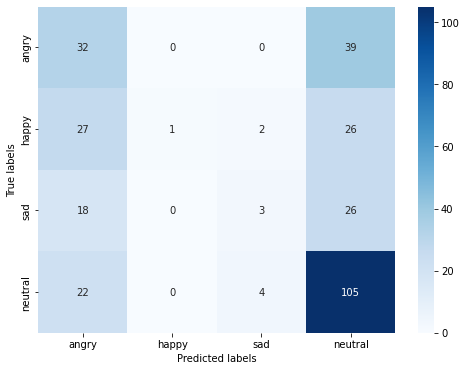

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the class names
class_names = ['angry', 'happy', 'sad', 'neutral']

# Compute the confusion matrix
cm = confusion_matrix(y_arg, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# FOLD 3

In [ ]:
### FOLD 2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize

X_train, y_train = specs[trx[2]], labels[trx[2]]
X_test, y_test = specs[tsx[2]], labels[tsx[2]]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=727)
y_bin = label_binarize(y_train, classes=['angry', 'happy', 'sad', 'neutral',])
y_bin2 = label_binarize(y_test, classes=['angry', 'happy', 'sad', 'neutral',])
y_val_bin = label_binarize(y_val, classes=['angry', 'happy', 'sad', 'neutral',])

Epoch 1/25
23/23 [==============================] - 30s 871ms/step - loss: 332.6290 - accuracy: 0.2781 - val_loss: 198.9453 - val_accuracy: 0.4699
Epoch 2/25
23/23 [==============================] - 16s 686ms/step - loss: 128.2209 - accuracy: 0.4068 - val_loss: 76.7978 - val_accuracy: 0.4699
Epoch 3/25
23/23 [==============================] - 16s 681ms/step - loss: 57.2880 - accuracy: 0.4068 - val_loss: 44.4556 - val_accuracy: 0.4699
Epoch 4/25
23/23 [==============================] - 16s 680ms/step - loss: 40.2068 - accuracy: 0.4315 - val_loss: 37.9411 - val_accuracy: 0.4809
Epoch 5/25
23/23 [==============================] - 16s 679ms/step - loss: 37.1325 - accuracy: 0.4329 - val_loss: 36.3327 - val_accuracy: 0.4699
Epoch 6/25
23/23 [==============================] - 16s 681ms/step - loss: 36.8199 - accuracy: 0.4397 - val_loss: 36.6921 - val_accuracy: 0.4863
Epoch 7/25
23/23 [==============================] - 16s 682ms/step - loss: 37.0982 - accuracy: 0.4425 - val_loss: 36.7834 - val

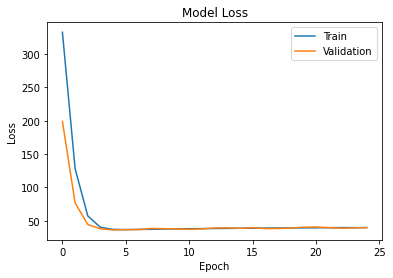

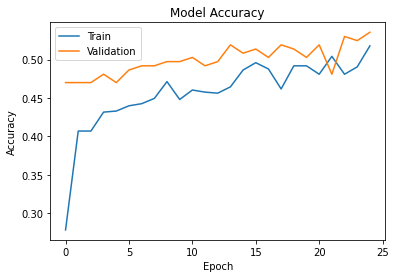

In [ ]:
hist3 = History()
model3 = create_model(32, 64, 128, 128, 0.5, 0.001, 0.0005)
model3.fit(X_train, y_bin, epochs=25, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist3])
plothist(hist3)

In [ ]:
from sklearn.metrics import classification_report

y_pred = model3.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

test_loss, test_acc = model3.evaluate(X_test, y_bin2)

print('Test accuracy:', test_acc)

f1 = f1_score(y_arg, y_pred, average='weighted')
print("F1-score:", f1)

print(classification_report(y_arg, y_pred))

10/10 [==============================] - 2s 175ms/step - loss: 39.7499 - accuracy: 0.5279
Test accuracy: 0.5278688669204712
F1-score: 0.4715268578093245
              precision    recall  f1-score   support

           0       0.49      0.57      0.53        67
           1       0.38      0.10      0.15        52
           2       0.25      0.09      0.13        45
           3       0.57      0.81      0.67       141

    accuracy                           0.53       305
   macro avg       0.43      0.39      0.37       305
weighted avg       0.48      0.53      0.47       305



In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

y_pred = model3.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

# Define the class names
class_names = ['angry', 'happy', 'sad', 'neutral']

# Compute the classification report
report = classification_report(y_arg, y_pred, target_names=class_names, output_dict=True)

# Convert the report to a dataframe
df_report = pd.DataFrame(report).transpose()

# Convert the decimals to percentages with 2 decimal places (excluding the last column)
df_report.iloc[:,:-1] = df_report.iloc[:,:-1].applymap(lambda x: f'{x:.2%}' if isinstance(x, float) else x)

# Style the dataframe
df_report = df_report.style.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]).set_precision(2)

# Display the dataframe
display(df_report)

10/10 [==============================] - 2s 174ms/step


<ipython-input-26-e5839b6ff508>:21: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_report = df_report.style.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]).set_precision(2)


,precision,recall,f1-score,support
angry,49.35%,56.72%,52.78%,67.00
happy,38.46%,9.62%,15.38%,52.00
sad,25.00%,8.89%,13.11%,45.00
neutral,57.29%,80.85%,67.06%,141.00
accuracy,52.79%,52.79%,52.79%,0.53
macro avg,42.52%,39.02%,37.08%,305.00
weighted avg,47.57%,52.79%,47.15%,305.00


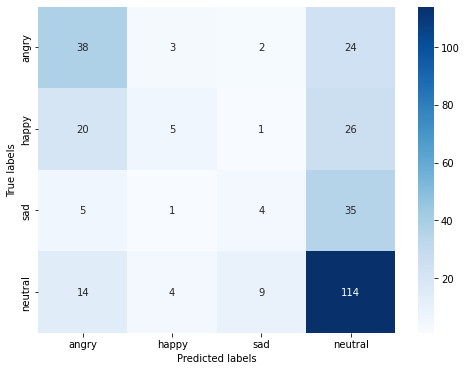

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the class names
class_names = ['angry', 'happy', 'sad', 'neutral']

# Compute the confusion matrix
cm = confusion_matrix(y_arg, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# FOLD 4 

In [ ]:
### FOLD 2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize

X_train, y_train = specs[trx[3]], labels[trx[3]]
X_test, y_test = specs[tsx[3]], labels[tsx[3]]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=727)
y_bin = label_binarize(y_train, classes=['angry', 'happy', 'sad', 'neutral',])
y_bin2 = label_binarize(y_test, classes=['angry', 'happy', 'sad', 'neutral',])
y_val_bin = label_binarize(y_val, classes=['angry', 'happy', 'sad', 'neutral',])

Epoch 1/25
23/23 [==============================] - 14s 330ms/step - loss: 44.8881 - accuracy: 0.3379 - val_loss: 22.3643 - val_accuracy: 0.4590
Epoch 2/25
23/23 [==============================] - 4s 167ms/step - loss: 14.1359 - accuracy: 0.4186 - val_loss: 8.2066 - val_accuracy: 0.4590
Epoch 3/25
23/23 [==============================] - 4s 165ms/step - loss: 6.0868 - accuracy: 0.4063 - val_loss: 4.5767 - val_accuracy: 0.4590
Epoch 4/25
23/23 [==============================] - 4s 166ms/step - loss: 4.0866 - accuracy: 0.3871 - val_loss: 3.6909 - val_accuracy: 0.4590
Epoch 5/25
23/23 [==============================] - 4s 166ms/step - loss: 3.5482 - accuracy: 0.4213 - val_loss: 3.4033 - val_accuracy: 0.4590
Epoch 6/25
23/23 [==============================] - 4s 166ms/step - loss: 3.3809 - accuracy: 0.4172 - val_loss: 3.3963 - val_accuracy: 0.4536
Epoch 7/25
23/23 [==============================] - 4s 166ms/step - loss: 3.3627 - accuracy: 0.4309 - val_loss: 3.3262 - val_accuracy: 0.4426
Ep

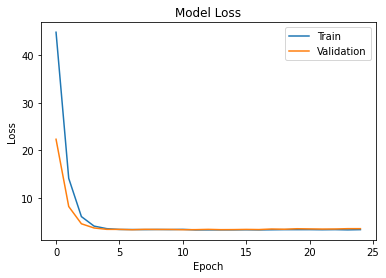

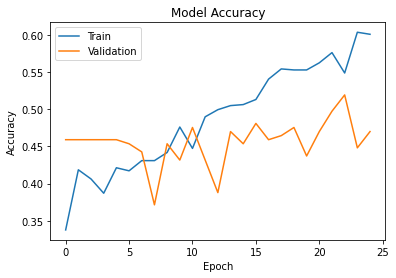

In [ ]:
hist4 = History()
model4 = create_model(32, 64, 128, 128, 0.5, 0.001, 0.0005)
model4.fit(X_train, y_bin, epochs=25, batch_size=32, verbose=1, shuffle=True,validation_data=(X_val, y_val_bin), callbacks=[hist4])
plothist(hist4)

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

y_pred = model4.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_arg = np.argmax(y_bin2, axis=1)

# Define the class names
class_names = ['angry', 'happy', 'sad', 'neutral']

# Compute the classification report
report = classification_report(y_arg, y_pred, target_names=class_names, output_dict=True)

# Convert the report to a dataframe
df_report = pd.DataFrame(report).transpose()

# Convert the decimals to percentages with 2 decimal places (excluding the last column)
df_report.iloc[:,:-1] = df_report.iloc[:,:-1].applymap(lambda x: f'{x:.2%}' if isinstance(x, float) else x)

# Style the dataframe
df_report = df_report.style.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]).set_precision(2)

# Display the dataframe
display(df_report)

10/10 [==============================] - 1s 83ms/step


<ipython-input-24-05cadfeb3c88>:21: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_report = df_report.style.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}]).set_precision(2)


,precision,recall,f1-score,support
angry,41.44%,64.79%,50.55%,71.00
happy,23.81%,8.93%,12.99%,56.00
sad,37.50%,6.52%,11.11%,46.00
neutral,57.32%,71.76%,63.73%,131.00
accuracy,48.68%,48.68%,48.68%,0.49
macro avg,40.02%,38.00%,34.59%,304.00
weighted avg,44.44%,48.68%,43.34%,304.00


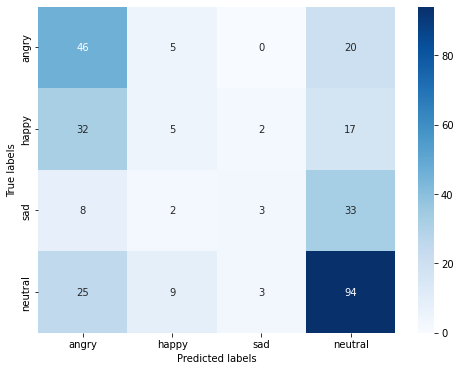

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the class names
class_names = ['angry', 'happy', 'sad', 'neutral']

# Compute the confusion matrix
cm = confusion_matrix(y_arg, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()